## The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [76]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

# Import Important Libraries
import sklearn
from sklearn.linear_model import LogisticRegression # importing Sklearn's logistic regression's module
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing # preprossing is what we do with the data before we run the learning algorithm
from sklearn.model_selection import train_test_split 
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
# import math

import matplotlib.pyplot as plt
%matplotlib inline

## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

In [77]:
# Load the .arff file
connect_4_dataset = arff.loadarff('../connect-4.arff')

# Convert to a numpy array
data = np.asarray(connect_4_dataset[0].tolist(), dtype=np.float32)

# Print the array
print(data)

[[0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 2.]
 ...
 [2. 2. 0. ... 0. 0. 1.]
 [2. 1. 0. ... 2. 0. 0.]
 [2. 1. 1. ... 0. 0. 0.]]


In [78]:
X = data[:, :-1]
y = data[:, -1:]

print('X:' + str(X.shape))
print('y:' + str(y.shape))

X:(67557, 42)
y:(67557, 1)


## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [79]:
# # Splitting the dataset 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,   
    test_size = 0.07, random_state=10, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.07, random_state=10, shuffle=True
)


# ! No need to scale since the data is already the same scale

In [80]:
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))


In [81]:
# Check to make sure everything is as expected
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t'  + str(X_val.shape))
print('y_val: \t'  + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))

print('X_train:' + str(X_train[0].shape))

X_train:(58430, 43)
y_train:(58430, 1)
X_val: 	(4398, 43)
y_val: 	(4398, 1)
X_test: (4729, 43)
y_test: (4729, 1)
X_train:(43,)


## 3) Setting up the output layer

### One-vs-all encoding
Our target is an integer in the range [0,..,9], so we will have 3 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.

In [82]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 3))
    for i in range(len(y)):
        y_vect[i, int(y[i])] = 1
    return y_vect

Converting the training and test targets to vectors 

In [83]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [84]:
print(y_train[0:4])
print(y_v_train[0:4])

[[1.]
 [0.]
 [2.]
 [2.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


## 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [85]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [86]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [87]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [88]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [89]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

## The Back Propagation Algorithm


In [90]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%100 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                # * Final layer code
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                    
                # * Hidden layer code
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
                    
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 43 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [91]:
nn_structure = [43, 30, 3]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 100)

Starting gradient descent for 100 iterations
Iteration 0 of 100


### Plotting the learning curve


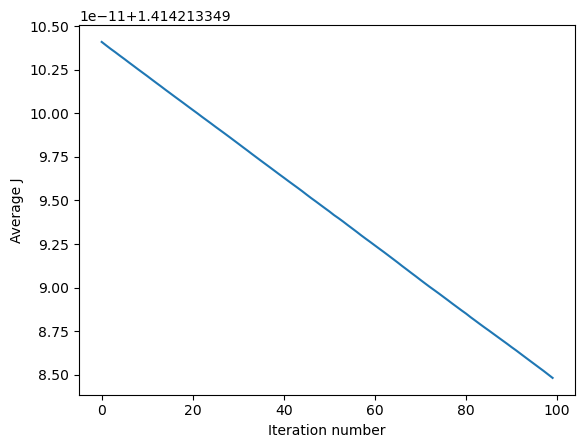

In [92]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

## 5) Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [93]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 65.55297102981604%


==============================================

## A. RELU function

### The activation function and its derivative

* Try using the **ReLU** activation function, $f(z) = \max(0,z)$. You will notice it is not differentiable at $0$, but you can use: $f'(z) = 0$ if $z<0$ and $f'(z)=1$ if $z\ge 0$.  (You can also try using the **leaky ReLU** activation function.)  For more information see https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning.  (The performance of the ReLU may surprise you.) <br><br>


In [ ]:
def f(z):
    return np.maximum(0, z)

def f_deriv(z):
    return np.where(z >= 0, 1, 0)

In [ ]:
nn_structure = [43, 30, 3]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


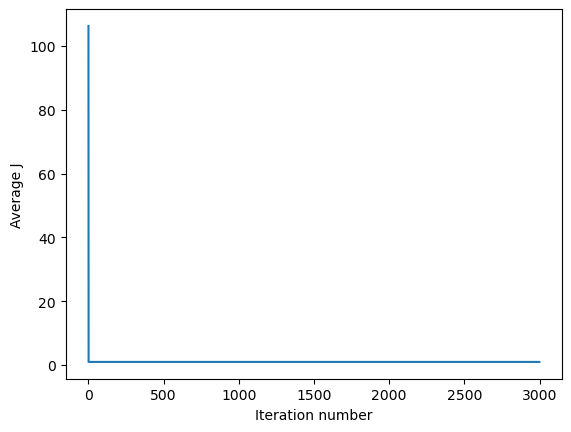

In [ ]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [ ]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 9.874826147426981%


## RELU Experience

Describe your experience (i.e. what did you try and how well did it peform).  What gave the best performance?

I replaced the activation functions/derivative definiton containing sigmoid function with the RELU. The accuracy went from 90.7% to 9.87%. The performance was very bad and that is surprising. This suggests that the ReLU activation function may not be well suited for this specific neural network architecture and dataset. It's possible that the network is too shallow or too deep for ReLU to perform well, or the hyperparameters such as learning rate, number of neurons per layer, or batch size may need to be adjusted. Best performance was achieved with the sigmoid activation function.


==============================================

## B. Tanh function

* Try using the **tanh** activation function, $f(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$.  The derivative of **tanh** is $f'(z)=1-(f(z))^2$.  For more information see http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/ <br><br>

In [ ]:
def f(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def f_deriv(z):
    return 1 - np.square(f(z))

In [ ]:
nn_structure = [43, 30, 3]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


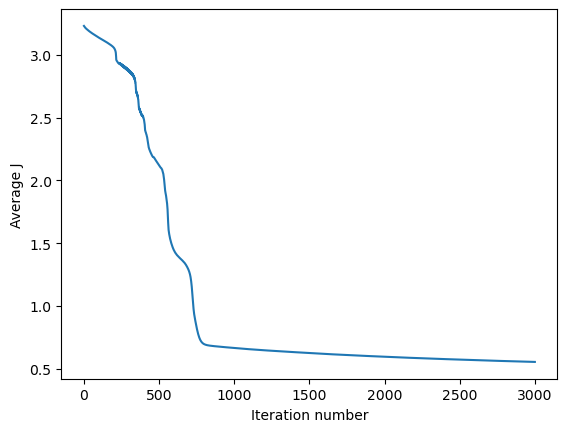

In [ ]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [ ]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 88.5952712100139%


## Tanh Experience

Describe your experience (i.e. what did you try and how well did it peform).  What gave the best performance?

I replaced the activation functions/derivative definiton containing sigmoid function with the Tanh function. The accuracy went from 90.7% to 88.6%. The performance was worse and that is surprising. Tanh is similar to sigmoid in that it is a smooth, S-shaped function that maps its inputs to a range between -1 and 1. However, like sigmoid, the Tanh function can also suffer from the vanishing gradients problem. This suggests that the Tanh activation function may not be well suited for this specific neural network architecture and dataset. It's possible that the network is too shallow or too deep for Tanh to perform well, or the hyperparameters such as learning rate, number of neurons per layer, or batch size may need to be adjusted. Best performance was achieved with the sigmoid activation function.


==============================================

## C. ELU function
* Try using the one of the other activation functions **ELU** (exponential linear unit) $ELU_{\alpha}(z)= \begin{cases}  \alpha(\exp (z)-1) & \text{if } z<  0 \\ z & \text{if } z\ge 0 \end{cases}$



In [ ]:
def f(z, alpha=0.25):
    return np.where(z >= 0, z, alpha * (np.exp(z) - 1))


def f_deriv(z, alpha=0.25):
    return np.where(z >= 0, 1, alpha * np.exp(z))

In [ ]:
nn_structure = [43, 30, 3]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000


C:\Users\gaura\AppData\Local\Temp\ipykernel_5360\484137132.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(z >= 0, z, alpha * (np.exp(z) - 1))
C:\Users\gaura\AppData\Local\Temp\ipykernel_5360\484137132.py:6: RuntimeWarning: overflow encountered in exp
  return np.where(z >= 0, 1, alpha * np.exp(z))


Iteration 1000 of 3000
Iteration 2000 of 3000


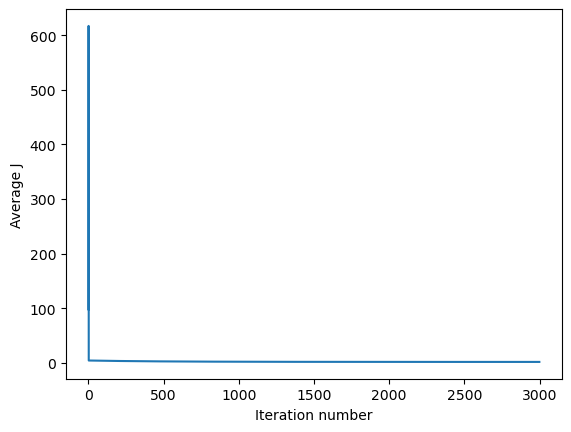

In [ ]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [ ]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 9.874826147426981%


C:\Users\gaura\AppData\Local\Temp\ipykernel_5360\484137132.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(z >= 0, z, alpha * (np.exp(z) - 1))


## ELU Experience

Describe your experience (i.e. what did you try and how well did it peform).  What gave the best performance?

I replaced the activation functions/derivative definiton containing sigmoid function with the ELU using alpha=0.25. The accuracy went from 90.7% to 9.87%. The performance was very bad and that is surprising. This suggests that the RLU activation function may not be well suited for this specific neural network architecture and dataset. It's possible that the network is too shallow or too deep for ELU to perform well, or the hyperparameters such as learning rate, number of neurons per layer, or batch size may need to be adjusted. Best performance was achieved with the sigmoid activation function.


==============================================

### UNDO the changes you made to the code above for future questions

In [ ]:

def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

==============================================

## D. Number of iterations

* Try changing the number of iterations


In [ ]:
nn_structure = [43, 30, 3]
    
# train the NN
# W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

# TODO change iterations below
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 10000)

Starting gradient descent for 10000 iterations
Iteration 0 of 10000
Iteration 1000 of 10000
Iteration 2000 of 10000
Iteration 3000 of 10000
Iteration 4000 of 10000
Iteration 5000 of 10000
Iteration 6000 of 10000
Iteration 7000 of 10000
Iteration 8000 of 10000
Iteration 9000 of 10000


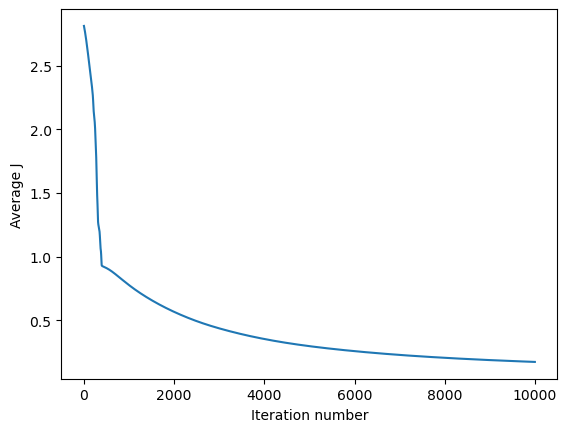

In [ ]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [ ]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 93.7413073713491%


## Number of iterations Experience

Describe your experience (i.e. what did you try and how well did it peform).  What gave the best performance?

I increased the number of iterations from 3000 to 10000. The accuracy went from 90.7% to 93.7%. This suggests that the neural network had not yet converged after 3000 iterations and required more iterations to reach a better solution.

However, increasing the number of iterations can also increase the risk of overfitting, where the model becomes too complex and starts to memorize the training data instead of generalizing to new data. To prevent overfitting, it's important to use appropriate regularization techniques such as dropout or L2 regularization, and to monitor the performance of the model on a validation set during training.




==============================================

## E. Number of hidden layers

* Try changing the number of hidden layers

In [ ]:
# TODO change nn_structure below
# nn_structure = [43, 30, 3]
nn_structure = [43, 30, 20, 3]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


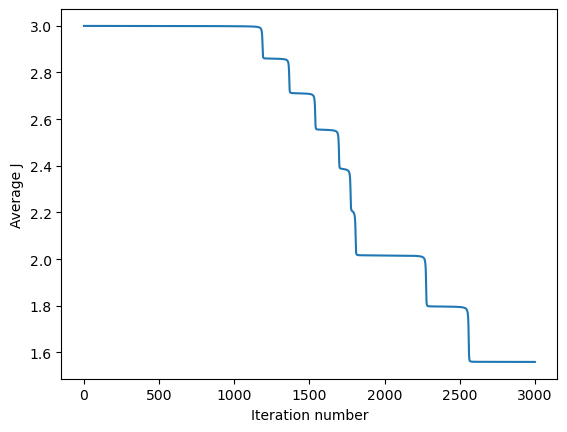

In [ ]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [ ]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 4)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 0.5563282336578581%


## Number of Hidden Layers Experience

Describe your experience (i.e. what did you try and how well did it peform).  What gave the best performance?

I increased the number of hidden layers from 1 to 2 and the neural network structure from  [43, 30, 3] to [43, 30, 20, 10]. The accuracy went from 90.7% to 0.6%. This is a surprising result. This suggests that the additional layer and neurons may have introduced too much complexity to the model, making it difficult to train effectively.

To improve the performance of the neural network with multiple hidden layers, it's important to use appropriate regularization techniques such as dropout or L2 regularization, and to carefully tune the hyperparameters such as learning rate and number of neurons per layer. 

In some cases, increasing the number of hidden layers may not improve performance, and a simpler model with fewer layers may be more effective. The optimal number of layers and neurons depends on the complexity of the problem and the amount of available data.



==============================================

## F. Weights Initialization
* Try initializing the weights using one of the techniques mentioned in the lecture 

[![image-21.png](https://i.postimg.cc/sDDHnDgS/image-21.png)](https://postimg.cc/K4w5jbLv)

Here's the technique I use it is called Xavier Initialization

[![image.png](https://i.postimg.cc/760g3SCb/image.png)](https://postimg.cc/njVjZjGt)

In [ ]:

def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = np.random.normal(loc=0, scale=np.sqrt(1/nn_structure[l-1]), size=(nn_structure[l], nn_structure[l-1]))
        b[l] = np.zeros((nn_structure[l],))
    return W, b

In [ ]:
# TODO change nn_structure below
nn_structure = [43, 30, 3]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


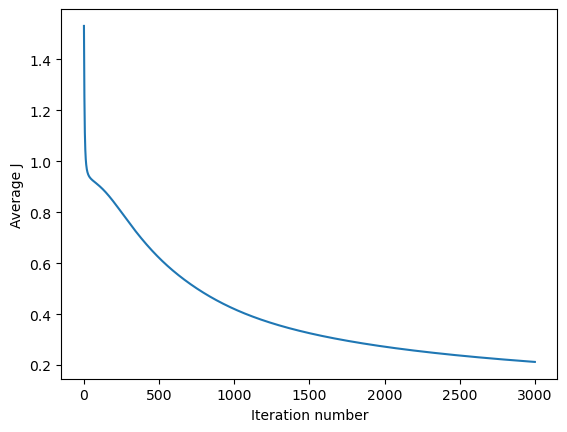

In [ ]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [ ]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 95.41029207232266%


## Weights Initialization Experience

Describe your experience (i.e. what did you try and how well did it peform).  What gave the best performance?

I used the Xavier initialization method instead of random initialization. The accuracy went from 90.7% to 95.4%. The initialization of weights in a neural network can significantly impact the performance of the model. Random initialization can result in large initial weights that may cause vanishing or exploding gradients, making the training process more difficult. The Xavier initialization method can help address these issues by scaling the initial weights appropriately. This suggests that the initial weights were a bottleneck in the training process and that the Xavier initialization method helped the model converge to a better solution more quickly.

The Xavier initialization method is based on the number of input and output neurons for each layer, and it aims to scale the initial weights such that the variance of the output of each neuron is approximately equal to the variance of its input. This can help prevent vanishing or exploding gradients and make the training process more stable.

It's important to note that the optimal initialization method may depend on the specific neural network architecture and dataset. In some cases, other initialization methods such as random initialization may be more effective.



==============================================

### UNDO the changes you made to the code above for future questions

In [ ]:

def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

==============================================

## G. Adding Regularization


* Add a regularization term to the cost function. 
$$ J(W,b)
= \frac{1}{N}
{\Big [}\sum_{i=1}^N
 J(W,b,{\bf x}^{(i)},y^{(i)}){\Big ]}
+ \frac{\lambda}{2}\sum_{\ell}\sum_{i}\sum_j (W^{(\ell)}_{ij})^2$$

The partial derivative would be: 
$$\frac{\partial J(W,b)}{\partial W^{(\ell)}_{ij}}
= \frac{1}{N}
{\Big [}\sum_{i=1}^N
\frac{\partial J(W,b,{\bf x}^{(i)},y^{(i)})}{\partial W^{(\ell)}_{ij}} {\Big ]}
+ {\lambda} W^{(\ell)}_{ij}$$ where ${\bf x}^{(i)},y^{(i)}$ are the $i$th training example.  <br><br>


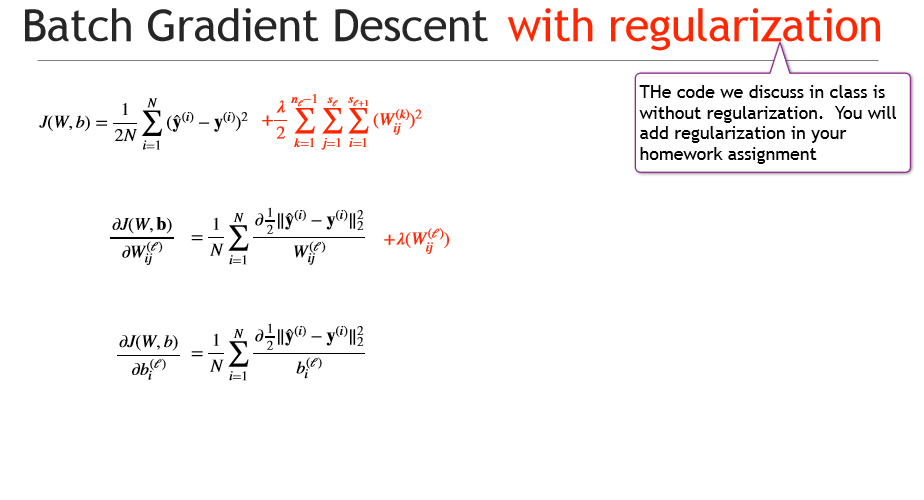

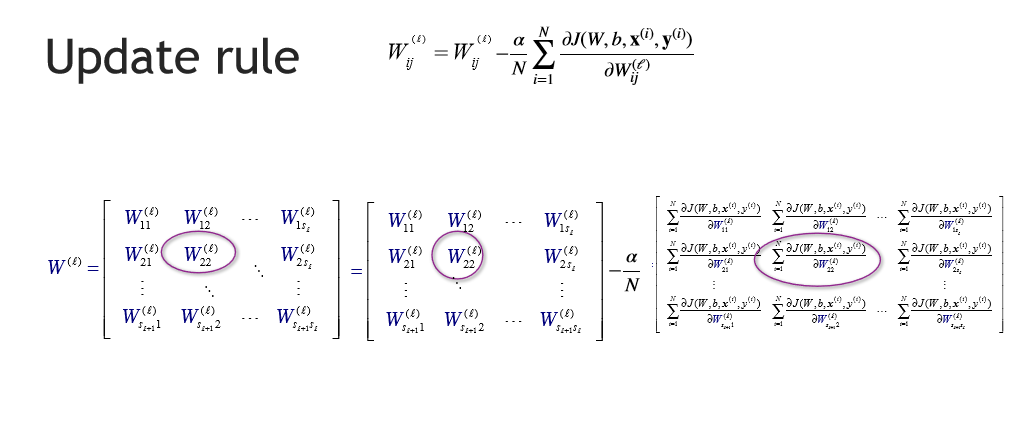

In [ ]:
def train_nn_regularization(nn_structure, X, y, lambd=0.001, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                # * Final layer code
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                    
                # * Hidden layer code
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
                    
        # perform the gradient descent step for the weights in each layer
        
        
        # @ ML TAs Regulatization Change made below
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * (tri_W[l]+lambd*W[l]))
            b[l] += -alpha * (1.0/N * (tri_b[l]))
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [ ]:
# TODO change nn_structure below
nn_structure = [43, 30, 10]

# train the NN
W, b, avg_cost_func = train_nn_regularization(nn_structure, X_train, y_v_train, 0.1, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


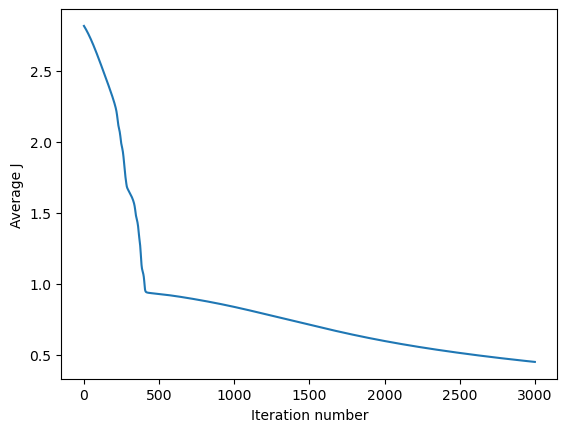

In [ ]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [ ]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 87.20445062586927%


## L2 Regularization Experience

Describe your experience (i.e. what did you try and how well did it peform).  What gave the best performance?

I used L2 Regularization with lambd=0.001. The accuracy went from 90.7% to 87.2%. L2 Regularization works by adding a penalty term to the loss function during training that encourages the weights to be small. This can help prevent the model from becoming too complex and memorizing the training data, leading to better generalization performance on new data.

In some cases, other regularization techniques such as dropout or L1 regularization may be more effective than L2 regularization. It's important to experiment with different regularization techniques and hyperparameters to find the best combination for your specific problem. 

This suggests that the regularization may have been too strong or that the lambda value may not have been optimal for the specific neural network architecture and dataset.

To improve the performance of the neural network with L2 regularization, I can try adjusting the lambda value and monitoring the performance on a validation set to find the optimal value but 0.001 was optimal for me. 
